In [1]:
!pip install -q transformers datasets evaluate scikit-learn matplotlib seaborn streamlit[cli] --upgrade
!pip install -U transformers

In [2]:
import re
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
import evaluate
import os
from accelerate import PartialState
PartialState._reset_state()

In [3]:
MODEL_NAME = "distilbert-base-uncased"
DATASET_NAME = "emotion"
MAX_LENGTH = 128
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_EPOCHS = 10
EVAL_STRATEGY = "epoch"
EARLYSTOP_PATIENCE = 2
OUTPUT_DIR = "./results"
SEED = 42

In [4]:
def clean_text(text):
    if text is None:
        return ""
    text = str(text)
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s.,!?']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [5]:
raw_ds = load_dataset("dair-ai/emotion")
if "train" in raw_ds:
    df_train = pd.DataFrame(raw_ds["train"])
else:
    df_train = pd.DataFrame(raw_ds)
if "test" in raw_ds:
    df_test = pd.DataFrame(raw_ds["test"])
else:
    df_test = pd.DataFrame([])

combined = pd.concat([df_train, df_test], ignore_index=True)
combined = combined.sample(frac=1, random_state=SEED).reset_index(drop=True)

if "text" not in combined.columns:
    possible_text_cols = [c for c in combined.columns if combined[c].dtype == object]
    if len(possible_text_cols) == 0:
        raise ValueError("No text-like column found in dataset.")
    text_col = possible_text_cols[0]
else:
    text_col = "text"

label_col = "label" if "label" in combined.columns else None
if label_col is None:
    numeric_cols = [c for c in combined.columns if combined[c].dtype in [int, np.int64]]
    if len(numeric_cols) == 0:
        raise ValueError("No label column found.")
    label_col = numeric_cols[0]

# Clean text
combined["text"] = combined[text_col].apply(clean_text)
combined = combined[["text", label_col]].rename(columns={label_col: "label"})
combined.head()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,text,label
0,i figure that if i do enough radio appearances...,0
1,when a boy tried to fool me so he would be ok ...,3
2,im not feeling too hot this week so it has bee...,2
3,i feel rejected like my peers dont really unde...,0
4,i feel privileged to have narrated erik prince...,1


In [6]:
train_df, temp_df = train_test_split(combined, test_size=0.20, random_state=SEED, stratify=combined["label"])
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=SEED, stratify=temp_df["label"])

print("sizes:", len(train_df), len(val_df), len(test_df))

sizes: 14400 1800 1800


In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_LENGTH)

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds = val_ds.map(tokenize_fn, batched=True)
test_ds = test_ds.map(tokenize_fn, batched=True)

columns_to_return = ["input_ids", "attention_mask", "label"]
train_ds.set_format(type="torch", columns=columns_to_return)
val_ds.set_format(type="torch", columns=columns_to_return)
test_ds.set_format(type="torch", columns=columns_to_return)


Map:   0%|          | 0/14400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

In [8]:
num_labels = int(combined["label"].nunique())
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    prec = precision_metric.compute(predictions=preds, references=labels, average="weighted")["precision"]
    rec = recall_metric.compute(predictions=preds, references=labels, average="weighted")["recall"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}


In [10]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy=EVAL_STRATEGY,
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=SEED,
    fp16=torch.cuda.is_available()
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLYSTOP_PATIENCE)],
)

In [16]:
import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=SEED,
    fp16=torch.cuda.is_available(),
    report_to="none"    # <--- Make sure Trainer does NOT use W&B
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLYSTOP_PATIENCE)],
)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.125100,0.204896,0.941667,0.942249,0.941667,0.941815
2,0.087800,0.213469,0.936667,0.937227,0.936667,0.936798
3,0.060200,0.271603,0.938333,0.939735,0.938333,0.938549


TrainOutput(global_step=2700, training_loss=0.07962737741293731, metrics={'train_runtime': 219.9332, 'train_samples_per_second': 654.744, 'train_steps_per_second': 40.922, 'total_flos': 1430749959782400.0, 'train_loss': 0.07962737741293731, 'epoch': 3.0})

In [20]:
test_results = trainer.evaluate(test_ds)
print("Test set metrics:", test_results)


Test set metrics: {'eval_loss': 0.26122453808784485, 'eval_accuracy': 0.9283333333333333, 'eval_precision': 0.9292160040919344, 'eval_recall': 0.9283333333333333, 'eval_f1': 0.9283600188684734, 'eval_runtime': 2.2487, 'eval_samples_per_second': 800.454, 'eval_steps_per_second': 50.251, 'epoch': 3.0}


Classification Report:
               precision    recall  f1-score   support

           0     0.9766    0.9543    0.9653       525
           1     0.9533    0.9455    0.9494       605
           2     0.8511    0.8163    0.8333       147
           3     0.8902    0.9342    0.9116       243
           4     0.8590    0.9306    0.8933       216
           5     0.8772    0.7812    0.8264        64

    accuracy                         0.9283      1800
   macro avg     0.9012    0.8937    0.8966      1800
weighted avg     0.9292    0.9283    0.9284      1800



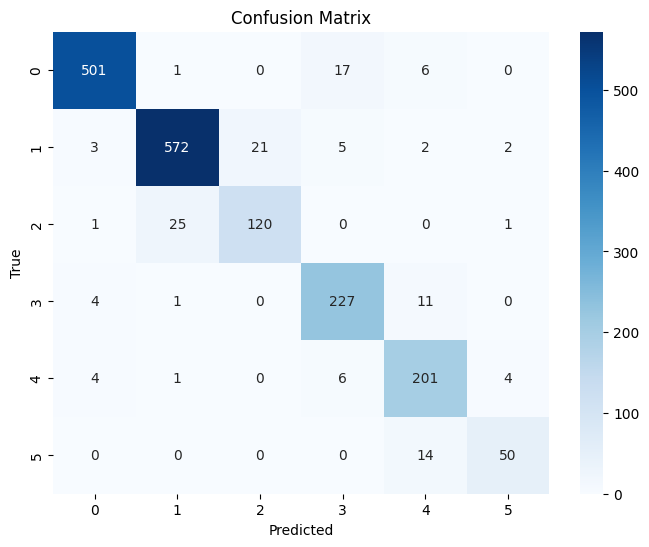

In [21]:
pred_output = trainer.predict(test_ds)
preds = np.argmax(pred_output.predictions, axis=-1)
labels = pred_output.label_ids
print("Classification Report:\n", classification_report(labels, preds, digits=4))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [22]:
MODEL_DIR = "./fine_tuned_model"
os.makedirs(MODEL_DIR, exist_ok=True)
trainer.save_model(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)
print(f"Saved model to {MODEL_DIR}")

Saved model to ./fine_tuned_model
